Before Oversampling: [2575 1045]
After Oversampling: [2575 2575]

Confusion Matrix:
 [[768 329]
 [  0 455]]

Accuracy: 0.7880154639175257
Precision: 0.5803571428571429
Recall: 1.0
F1 Score: 0.7344632768361582


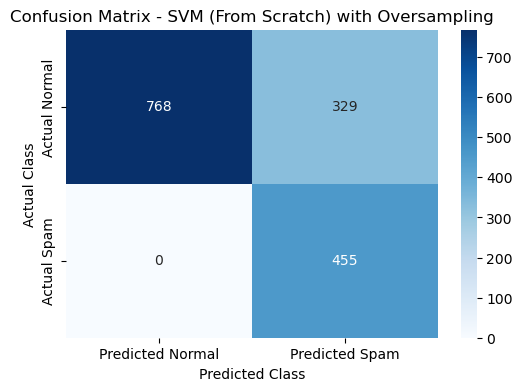


----- SAMPLE TEST RESULTS -----

Congratulations! You have won free cash prize!!!  --->  SPAM
The meeting is scheduled for tomorrow morning. Please confirm your availability.  --->  SPAM


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from imblearn.over_sampling import RandomOverSampler
import seaborn as sns
import matplotlib.pyplot as plt
import re

# -------------------------------------------------------
# 1) LOAD DATA
# -------------------------------------------------------
df = pd.read_csv("emails.csv")

data = df.drop(columns=['Email No.'])
X = data.drop(columns=['Prediction']).values
y = data['Prediction'].values

# Convert labels to {-1, +1} for SVM from scratch
y = np.where(y == 0, -1, 1)

# -------------------------------------------------------
# 2) TRAIN / TEST SPLIT
# -------------------------------------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

print("Before Oversampling:", np.bincount(np.where(y_train==-1,0,1)))

# -------------------------------------------------------
# 3) OVERSAMPLING USING BUILT-IN TECHNIQUE
# -------------------------------------------------------
oversample = RandomOverSampler(random_state=42)
X_train_res, y_train_res = oversample.fit_resample(X_train, y_train)

print("After Oversampling:", np.bincount(np.where(y_train_res==-1,0,1)))

# -------------------------------------------------------
# 4) SVM FROM SCRATCH CLASS
# -------------------------------------------------------
class SVM_From_Scratch:
    def __init__(self, learning_rate=0.0001, lambda_param=0.01, n_iters=600):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        
    def fit(self, X, y):
        n_samples, n_features = X.shape
        self.w = np.zeros(n_features)
        self.b = 0
        
        for _ in range(self.n_iters):
            for idx, x in enumerate(X):
                condition = y[idx] * (np.dot(x, self.w) + self.b) >= 1
                if condition:
                    self.w -= self.lr * (2 * self.lambda_param * self.w)
                else:
                    self.w -= self.lr * (2 * self.lambda_param * self.w - x * y[idx])
                    self.b -= self.lr * (-y[idx])
                    
    def predict(self, X):
        return np.where((np.dot(X, self.w) + self.b) >= 0, 1, -1)

# -------------------------------------------------------
# 5) TRAIN MODEL
# -------------------------------------------------------
svm = SVM_From_Scratch()
svm.fit(X_train_res, y_train_res)

# -------------------------------------------------------
# 6) PREDICT
# -------------------------------------------------------
y_pred = svm.predict(X_test)

# Convert for evaluation
y_test_eval = np.where(y_test == -1, 0, 1)
y_pred_eval = np.where(y_pred == -1, 0, 1)

# -------------------------------------------------------
# 7) METRICS
# -------------------------------------------------------
cm = confusion_matrix(y_test_eval, y_pred_eval)
acc = accuracy_score(y_test_eval, y_pred_eval)
prec = precision_score(y_test_eval, y_pred_eval)
rec = recall_score(y_test_eval, y_pred_eval)
f1 = f1_score(y_test_eval, y_pred_eval)

print("\nConfusion Matrix:\n", cm)
print("\nAccuracy:", acc)
print("Precision:", prec)
print("Recall:", rec)
print("F1 Score:", f1)

# -------------------------------------------------------
# 8) CONFUSION MATRIX HEATMAP
# -------------------------------------------------------
plt.figure(figsize=(6,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=["Predicted Normal", "Predicted Spam"],
            yticklabels=["Actual Normal", "Actual Spam"])
plt.title("Confusion Matrix - SVM (From Scratch) with Oversampling")
plt.ylabel("Actual Class")
plt.xlabel("Predicted Class")
plt.show()

# -------------------------------------------------------
# 9) CLASSIFY NEW EMAIL TEXT
# -------------------------------------------------------
bow_words = data.drop(columns=['Prediction']).columns.tolist()
word_to_index = {word: idx for idx, word in enumerate(bow_words)}

def classify_email(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    words = text.split()
    vec = np.zeros(len(bow_words))
    for word in words:
        if word in word_to_index:
            vec[word_to_index[word]] += 1
    result = svm.predict(vec.reshape(1, -1))[0]
    return "SPAM" if result == 1 else "HAM (Normal)"



In [4]:
# Sample Tests
print("\n----- SAMPLE TEST RESULTS -----\n")
tests = [
    "Congratulations! You have won free cash prize!!!",
    "The requested information has been added to the project folder. Please check it."
]
for t in tests:
    print(t, " ---> ", classify_email(t))



----- SAMPLE TEST RESULTS -----

Congratulations! You have won free cash prize!!!  --->  SPAM
The requested information has been added to the project folder. Please check it.  --->  SPAM
